In [3]:
import tensorflow   # machine learning library
import stellargraph   # tools for graphs
import networkx   # more tools for graphs
import numpy   # scientific computation and variable formats library
import matplotlib   # plotting 
import matplotlib.animation as animation    # joining plots in animations
import plotly.graph_objects as plot_graph   # fancy plotting
import os.path   # interaction with  files and filenames
import pandas   # library for loading and organising data
import datetime   # calendar and dates handling
import re   # I'm using regex, apologies

Please notice, to open jupyter in custom directory use:
>jupyter notebook --notebook-dir=[your_directory]

Expecting file hierarchy:
    <ul>root/
        <li>Antarctica_research_2020/
            <ul>.git/</ul>
            <ul>.gitignore</ul>
            <ul>readme.md</ul>
            <ul>notebook.ipynb</ul>
            <ul>img/
                    <ul>example_entry.jpg</ul>
            </ul>
    </li>
        <li>data/
            <ul>Sesja 1.xlsx</ul>
            <ul>.</ul>
            <ul>.</ul>
            <ul>Sesja 26.xlsx</ul></li>
    </ul>

In [4]:
# Let me write in advantage examined people occupations:
ppl_professions = {1: "fisherman",
                  2: "cook",
                  3: "medic",
                  4: "deputy technical manager",
                  5: "carpenter",
                  6: "driver",   # UWAGA - nr 6 przybył na stację 25.04.79r -> present from session no. 10
                  7: "technician",
                  8: "chemist",
                  9: "meteorologist",
                  10: "ichthyologist",   # study of fish
                  11: "magnetologist",
                  12: "seismologist",
                  13: "biologist",
                  14: "electrician",
                  15: "radiotelegraphist",
                  16: "psychologist",
                  17: "electronics engineer",
                  18: "meteorologist",
                  19: "microbiologist",
                  20: "parasitologist",
                  21: "botanist"   # data is missing for sessions 1-4
                  }

Before I load the source data, let me explain what and why I'll be doing with it.

![An example chart filled by person no. 1](img/example_entry.jpg)

Above, you can see an example entry chart, filled up on 29.12.78.
Each of 21 examined people had been filling such charts during every session, which took place every two weeks.
On a chart, an examined person marked his subjective possition and positions of others, as he saw fit.
As the experiment continued, people changed their views about each other, and thus changed the positions marked
on those charts. This, albeit simple method give us an insight about how social standings of each individual
changed in regards to other interconnected changes.

#### My goal is to answer some very basic questions about how those people relations shaped 40 years ago when they were stationed near the south pole, on Antarctica's coast.

First I load the data and create some simple classes to handle it easier, then I'll use simple statistics and basic graph operations to find out what was going on.

### First, let me load and adjust the given data:

In [5]:
data_path = "../data/"
file_list = [name for name in os.listdir(data_path)]
print(file_list)

['Sesja 1.xlsx', 'Sesja 10.xlsx', 'Sesja 11.xlsx', 'Sesja 12.xlsx', 'Sesja 13.xlsx', 'Sesja 14.xlsx', 'Sesja 15.xlsx', 'Sesja 16.xlsx', 'Sesja 17.xlsx', 'Sesja 18.xlsx', 'Sesja 19.xlsx', 'Sesja 2.xlsx', 'Sesja 20.xlsx', 'Sesja 21.xlsx', 'Sesja 22.xlsx', 'Sesja 23.xlsx', 'Sesja 24.xlsx', 'Sesja 25.xlsx', 'Sesja 26.xlsx', 'Sesja 3.xlsx', 'Sesja 4.xlsx', 'Sesja 5.xlsx', 'Sesja 6.xlsx', 'Sesja 7.xlsx', 'Sesja 8.xlsx', 'Sesja 9.xlsx']


In [6]:
# Sessions order is important, let me get sorted file info
sorted_filenames = dict()
for name in file_list:
    list_of_digits = list(map(int, filter(str.isdigit, name)))
    sorted_filenames[name] = list_of_digits[0] if len(list_of_digits) == 1 else list_of_digits[1] + list_of_digits[0]*10
sorted_filenames = sorted(sorted_filenames.items(), key=lambda el: el[1])
sorted_filenames = {val: key for key, val in sorted_filenames}
print(sorted_filenames)

{1: 'Sesja 1.xlsx', 2: 'Sesja 2.xlsx', 3: 'Sesja 3.xlsx', 4: 'Sesja 4.xlsx', 5: 'Sesja 5.xlsx', 6: 'Sesja 6.xlsx', 7: 'Sesja 7.xlsx', 8: 'Sesja 8.xlsx', 9: 'Sesja 9.xlsx', 10: 'Sesja 10.xlsx', 11: 'Sesja 11.xlsx', 12: 'Sesja 12.xlsx', 13: 'Sesja 13.xlsx', 14: 'Sesja 14.xlsx', 15: 'Sesja 15.xlsx', 16: 'Sesja 16.xlsx', 17: 'Sesja 17.xlsx', 18: 'Sesja 18.xlsx', 19: 'Sesja 19.xlsx', 20: 'Sesja 20.xlsx', 21: 'Sesja 21.xlsx', 22: 'Sesja 22.xlsx', 23: 'Sesja 23.xlsx', 24: 'Sesja 24.xlsx', 25: 'Sesja 25.xlsx', 26: 'Sesja 26.xlsx'}


In [7]:
# Loading data
data_dict = dict()
for key, val in sorted_filenames.items():
    data_dict[key] = pandas.read_excel(data_path + val, header=None, dtype=object)

In [8]:
rand_int = int(numpy.random.rand() * 26) + 1
data_dict[rand_int].head(4)
# An example:

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,NaN,Pozycja osoby,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,N = 21,NaN,NaN,1979-08-26 00:00:00,NaN,NaN,NaN,ZIM18,NaN,NaN
1,Nr O.B.,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
2,1,2314,2512,2012,2014,2017,2019,2317,2307,2310,...,1909,2519,2517,2616,2509,2711,2814,1714,1716,1712
3,2,1814,2301,2712,3217,2220,1517,1709,2314,3026,...,1927,2821,0912,2105,1024,1330,1522,0818,0624,3531


The target format for data is a stellargraph graph for each session (session -> data recording occuring every two week). But before that, let me read the data into intermediate objects: Session(s) and Person(s).
    Session will hold data in respect to each source data file, organising entries into lists of coordinates marked by examined people - one list for one man for each session.
    Person will organise data in respect to a single individual. Each* individual hold data for all 26 sessions, for convienience repeated in several arrangements.
    
*except mr. 6th, since he arrived later

In [9]:
class Session(object):
    def __init__(self, raw_session_data):
        self.date = self.find_date(raw_session_data)
        self.relations = self.get_relations(raw_session_data) # dictionary of lists of tuples - column_number : [(x1, y1), (x2, y2), ...]
    
    def get_relations(self, raw_session_data) -> dict:
        rels = dict()
        col_no = len(ppl_professions)
        rels = {x: [] for x in ppl_professions.keys()}
        for person in range(2, col_no + 2):
            for entry in range(1, col_no + 1):
                string_value = str(raw_session_data.iloc[person, entry])
                subject_no = raw_session_data.iloc[person, 0]
                data_point = self.tuple_from_string(string_value)
                rels[subject_no].append(data_point)
        return rels
    
    def tuple_from_string(self, string) -> tuple:
        if string == 'nan':
            return None
        elif len(string) == 4:
            x = int(string[1]) + int(string[0]) * 10
            y = int(string[3]) + int(string[2]) * 10
            return (x, y)
        elif len(string) == 3:
            x = int(string[0])
            y = int(string[2]) + int(string[1]) * 10
            return (x, y)
        else:
            return None
    
    def find_date(self, raw_session_data) -> str:
        for key, col in raw_session_data.iteritems():
            for val in col:
                regex = re.search(r"\d{1,2}.\d{1,2}.\d{4}|\d{4}.\d{1,2}.\d{1,2}", str(val))
                if regex:
                    return regex.group()
                
    def __str__(self):
        random = int(numpy.random.rand() * len(ppl_professions))
        return "Session from " + self.date + " example entry: " + str(self.relations[random]) + " for " + str(random)

In [10]:
session_data = [Session(e) for e in data_dict.values()]
# An example entry:
print(session_data[-1])

Session from 1980-01-10 example entry: [(27, 19), (26, 21), (26, 25), (18, 27), (16, 24), (14, 10), (17, 30), (14, 16), (25, 11), (29, 22), (25, 18), (21, 32), (22, 17), (17, 21), (13, 13), (19, 23), (27, 8), (17, 16), (18, 35), (16, 13), (23, 20)] for 11


In [11]:
class Person(object):
    def __init__(self, person_no, particular_person_profession, session_data):
        self.person_no = person_no
        self.profession = particular_person_profession
        self.sessions_dict = self.get_all_relations(session_data)
        self.relations_vector = self.get_all_relative_vectors(self.sessions_dict)
        self.distances = self.get_all_distances(self.relations_vector)
        
    def get_all_relations(self, session_data) -> dict:
        out_dict = {x: [] for x in sorted_filenames.keys()}
        for no in out_dict.keys():
            out_dict[no] = session_data[no - 1].relations[self.person_no]
        return out_dict
    
    def get_all_relative_vectors(self, relations) -> dict:
        out_dict = {x: [] for x in sorted_filenames.keys()}
        for no, session in relations.items():
            for relation in session:
                if relation is not None and session[self.person_no - 1] is not None:
                    out_dict[no].append((relation[0] - session[self.person_no - 1][0], relation[1] - session[self.person_no - 1][1]))
                else:
                    out_dict[no].append(None)
        return out_dict
    
    def get_all_distances(self, vectors) -> dict:
        out_dict = {x: [] for x in sorted_filenames.keys()}
        for no, session in vectors.items():
            for vector in session:
                if vector is not None:
                    out_dict[no].append(self.calc_distance(vector[0], vector[1]))
                else:
                    out_dict[no].append(None)
        return out_dict
    
    def calc_distance(self, a, b) -> float:
        return numpy.sqrt(a ** 2 + b ** 2)
    
    def __str__(self):
        rand_session = int(numpy.random.rand() * 26)
        return "No. " + str(self.person_no) + " being " + self.profession + " with distances: " + str(self.distances[rand_session]) + " for session " + str(rand_session)

In [12]:
people_data = [Person(no, profession, session_data) for no, profession in ppl_professions.items()]
# An example:
rand_ppl = int(numpy.random.rand() * 21)
print(people_data[rand_ppl])

No. 3 being medic with distances: [3.0, 3.1622776601683795, 0.0, 2.23606797749979, 4.123105625617661, 6.082762530298219, 4.47213595499958, 2.8284271247461903, 2.23606797749979, 2.8284271247461903, 3.1622776601683795, 4.123105625617661, 2.23606797749979, 5.0990195135927845, 4.123105625617661, 4.47213595499958, 4.242640687119285, 3.0, 5.0, 3.1622776601683795, 5.0] for session 23


### Having defined sessions and persons, now I want to answer following questions:

##### What was general tendency of marking others on charts?

By general tendency I understand a value telling me if <b>people were viewing others</b> as closer or more far away after time passed. I'm going to get a mean distance for each session for each person and see how those changed, and check the slope of linear approximation of given sessions' mean values.

In [13]:
mean_distance_per_session_per_man = [[(sum(filter(None, distances))/(len(distances))) if len(distances) != 0 else None for distances in man.distances.values()] for man in people_data]
mean_distance_slope_for_man = []
mean_distances_for_man = []
mean_values_of_mean_distance_for_man = []
for y in mean_distance_per_session_per_man:
    y = list(filter(None, y))
    if y:
        x = range(len(y))
        mean_distances_for_man.append(y)
        a, b = numpy.polyfit(x, y, deg=1)   # y = a * x + b (approximated by least squares polynomial fit)
        mean_distance_slope_for_man.append(a)
        mean_values_of_mean_distance_for_man.append(numpy.mean(y))
        
findings = zip(ppl_professions.values(), mean_values_of_mean_distance_for_man, mean_distance_slope_for_man)
findings = sorted(findings, key = lambda x: x[1])

print("Occupation, mean distance and distance change tendency (above zero being more distancing)")
print()
for entry in findings:
    print(f"{entry[0]:25} | {entry[1]:8.4f} | {entry[2]:8.4f}")
print()
print("Average change for mean distance slope is ", numpy.mean(mean_distance_slope_for_man))
print("Standard deviation for mean distance slope is ", numpy.std(mean_distance_slope_for_man))

Occupation, mean distance and distance change tendency (above zero being more distancing)

biologist                 |   4.3112 |   0.0771
medic                     |   4.4377 |   0.0976
electronics engineer      |   4.5907 |   0.0967
carpenter                 |   4.6362 |   0.0078
microbiologist            |   4.9219 |   0.0203
meteorologist             |   4.9442 |   0.0114
fisherman                 |   5.1634 |  -0.0619
ichthyologist             |   5.7443 |   0.0561
psychologist              |   6.3800 |   0.0630
deputy technical manager  |   6.6229 |   0.1470
parasitologist            |   8.0027 |   0.3074
driver                    |   8.1935 |  -0.2298
seismologist              |   9.1061 |   0.1680
technician                |   9.3022 |  -0.0019
botanist                  |   9.6682 |  -0.0811
magnetologist             |  10.0467 |  -0.1854
meteorologist             |  10.1716 |   0.2147
electrician               |  11.1674 |  -0.0010
chemist                   |  12.3395 |  -0.03

Average change for mean distance slope is slighty positive, suggesting people felt more distant over time.
Let me plot the mean, the "range" of standard deviation, and see how those slopes fit in:

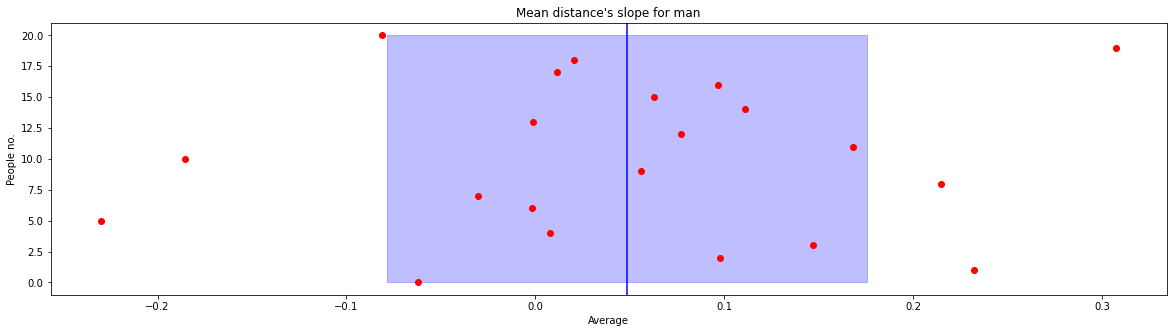

In [30]:
find_max = max(mean_distance_slope_for_man)
find_min = min(mean_distance_slope_for_man)

mean = numpy.mean(mean_distance_slope_for_man)
std_lim_1 = mean - numpy.std(mean_distance_slope_for_man)
std_lim_2 = mean + numpy.std(mean_distance_slope_for_man)
y = list(range(21))

matplotlib.pyplot.figure(figsize=(20, 5))
matplotlib.pyplot.title("Mean distance's slope for man")
matplotlib.pyplot.plot(mean_distance_slope_for_man, range(len(mean_distance_slope_for_man)), 'ro')
matplotlib.pyplot.ylabel("People no.")
matplotlib.pyplot.xlabel("Average")
matplotlib.pyplot.axvline(numpy.mean(mean_distance_slope_for_man), color='b')
matplotlib.pyplot.fill_betweenx(y, x1=std_lim_1, x2=std_lim_2,
                color='blue', alpha=0.25)
matplotlib.pyplot.show()

Let's see plots of the average distances for each session, for each person: 

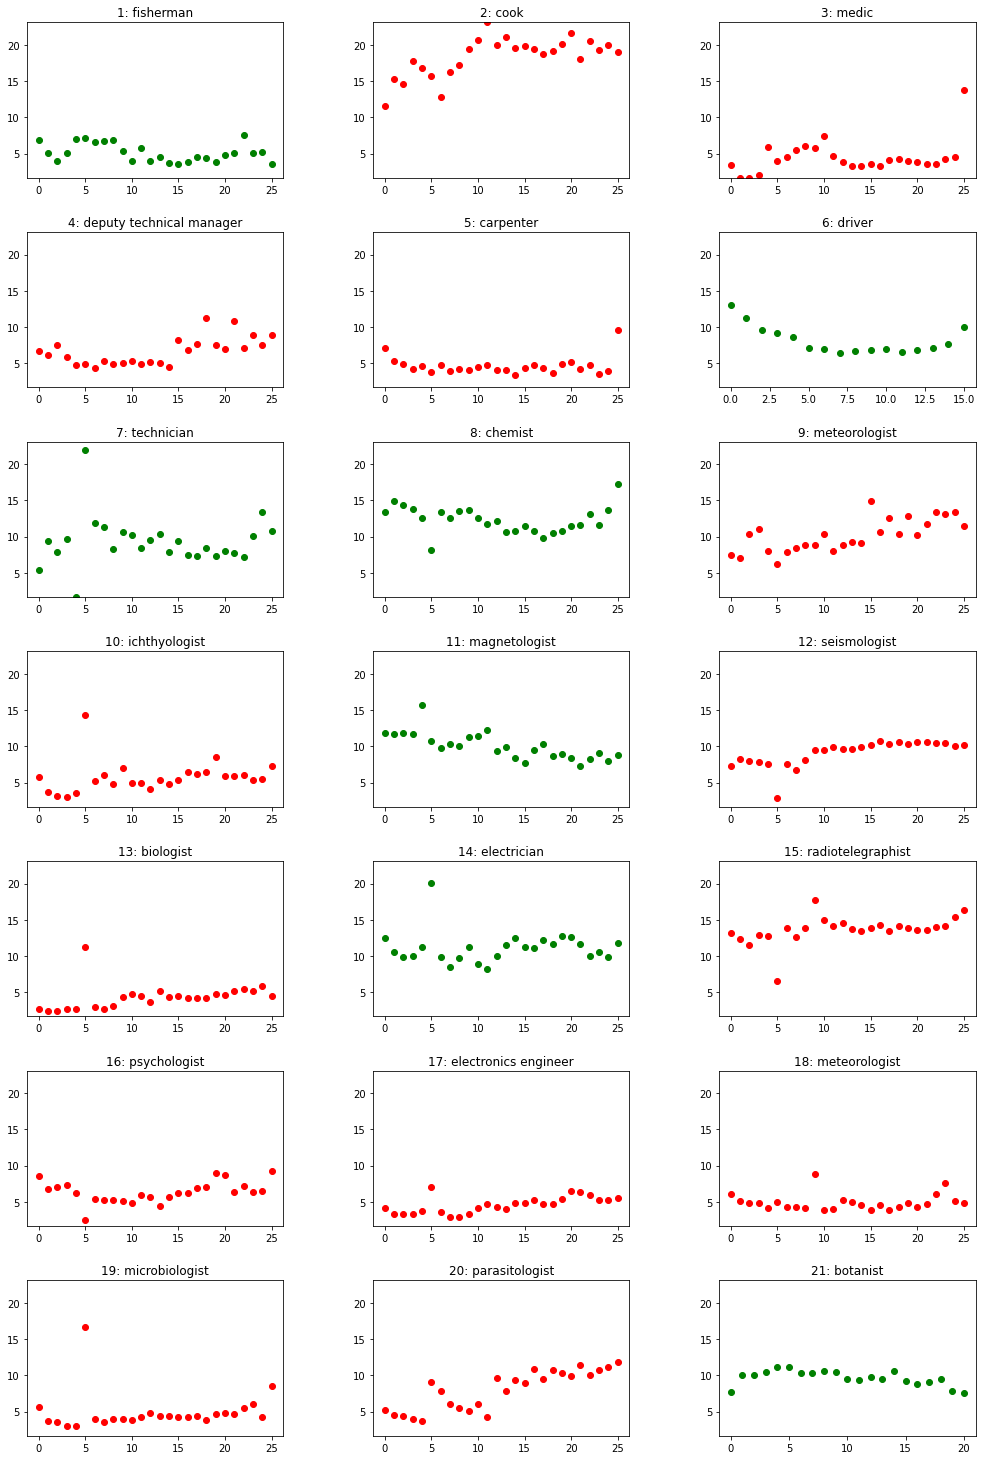

In [87]:
find_max = max([max(el) for el in mean_distances_for_man])
find_min = min([min(el) for el in mean_distances_for_man])
matplotlib.pyplot.figure(figsize=(17, 26))
plot_rows_no = 7
plot_cols_no = 3

for man in ppl_professions.keys():
    matplotlib.pyplot.subplot(plot_rows_no, plot_cols_no, man)
    matplotlib.pyplot.title(str(man) + ": " + ppl_professions[man])
    plot_color = 'go' if mean_distance_slope_for_man[man - 1] < 0 else 'ro'
    matplotlib.pyplot.plot(mean_distances_for_man[man - 1], plot_color) # -1 since I index plot_ppl from 0    
    matplotlib.pyplot.ylim(find_min, find_max)

matplotlib.pyplot.subplots_adjust(hspace=0.35, wspace=0.35)

matplotlib.pyplot.show()

##### What was general tendency how one was viewed by others?

Simillar to the above, I'm going to check how people were viewed by the others - I want to plot the average distance from people to the particular person by each session.

In [68]:
distances_per_session_per_man = [[dists for dists in person.distances.values()] for person in people_data]
average_incoming_distance_per_session_per_man = [[[] for dists in person.distances.values()] for person in people_data]

for i_m, man in enumerate(distances_per_session_per_man):
    for i_s, session in enumerate(man):
        for i_d, distance in enumerate(session):
            average_incoming_distance_per_session_per_man[i_m][i_s].append(distances_per_session_per_man[i_d][i_s][i_m])

for i_m, man in enumerate(distances_per_session_per_man):
    for i_s, session in enumerate(man):
        average_incoming_distance_per_session_per_man[i_m][i_s] = list(filter(None, average_incoming_distance_per_session_per_man[i_m][i_s]))
        if average_incoming_distance_per_session_per_man[i_m][i_s]:
            average_incoming_distance_per_session_per_man[i_m][i_s] = numpy.mean(average_incoming_distance_per_session_per_man[i_m][i_s])
        else:
            average_incoming_distance_per_session_per_man[i_m][i_s] = None

for i_m, man in enumerate(average_incoming_distance_per_session_per_man):
    average_incoming_distance_per_session_per_man[i_m] = list(filter(None, average_incoming_distance_per_session_per_man[i_m]))

average_incoming_distance_per_man = {man: numpy.mean(average_incoming_distance_per_session_per_man[man-1]) for man in ppl_professions.keys()} 
average_incoming_distance_slope_per_man = {man: numpy.polyfit(range(len(average_incoming_distance_per_session_per_man[man-1])), average_incoming_distance_per_session_per_man[man-1], deg=1) for man in ppl_professions.keys()}

findings = zip(ppl_professions.values(), average_incoming_distance_per_man.values(), average_incoming_distance_slope_per_man.values())
findings = sorted(findings, key = lambda x: x[1])

print("Occupation, mean incoming distance and change tendency: ")
print()
for entry in findings:
    print(f"{entry[0]:25} | {entry[1]:8.4f} | {entry[2][0]:8.4f}")
print()
print("Average change for average incoming distance slope is ", numpy.mean([x[0] for x in average_incoming_distance_slope_per_man.values()]))
print("Standard deviation for mean incoming distance slope is ", numpy.std([x[0] for x in average_incoming_distance_slope_per_man.values()]))

Occupation, mean incoming distance and change tendency: 

radiotelegraphist         |   6.5520 |   0.1092
chemist                   |   6.8173 |   0.0134
cook                      |   7.0159 |   0.1344
ichthyologist             |   7.1285 |   0.1163
parasitologist            |   7.5230 |   0.0466
fisherman                 |   7.6533 |   0.1386
botanist                  |   7.7930 |  -0.0296
biologist                 |   7.8184 |  -0.1171
meteorologist             |   8.0317 |  -0.0180
meteorologist             |   8.0328 |  -0.0851
driver                    |   8.1555 |  -0.0341
psychologist              |   8.2884 |  -0.0385
electronics engineer      |   9.1873 |  -0.0524
electrician               |   9.3357 |   0.0003
deputy technical manager  |   9.7012 |   0.1961
magnetologist             |   9.9061 |   0.1312
seismologist              |  10.0713 |  -0.0082
carpenter                 |  10.5473 |   0.1429
microbiologist            |  10.7806 |   0.0776
technician                |  1

Let me draw the charts showing how incoming average distances changed over time for each person:

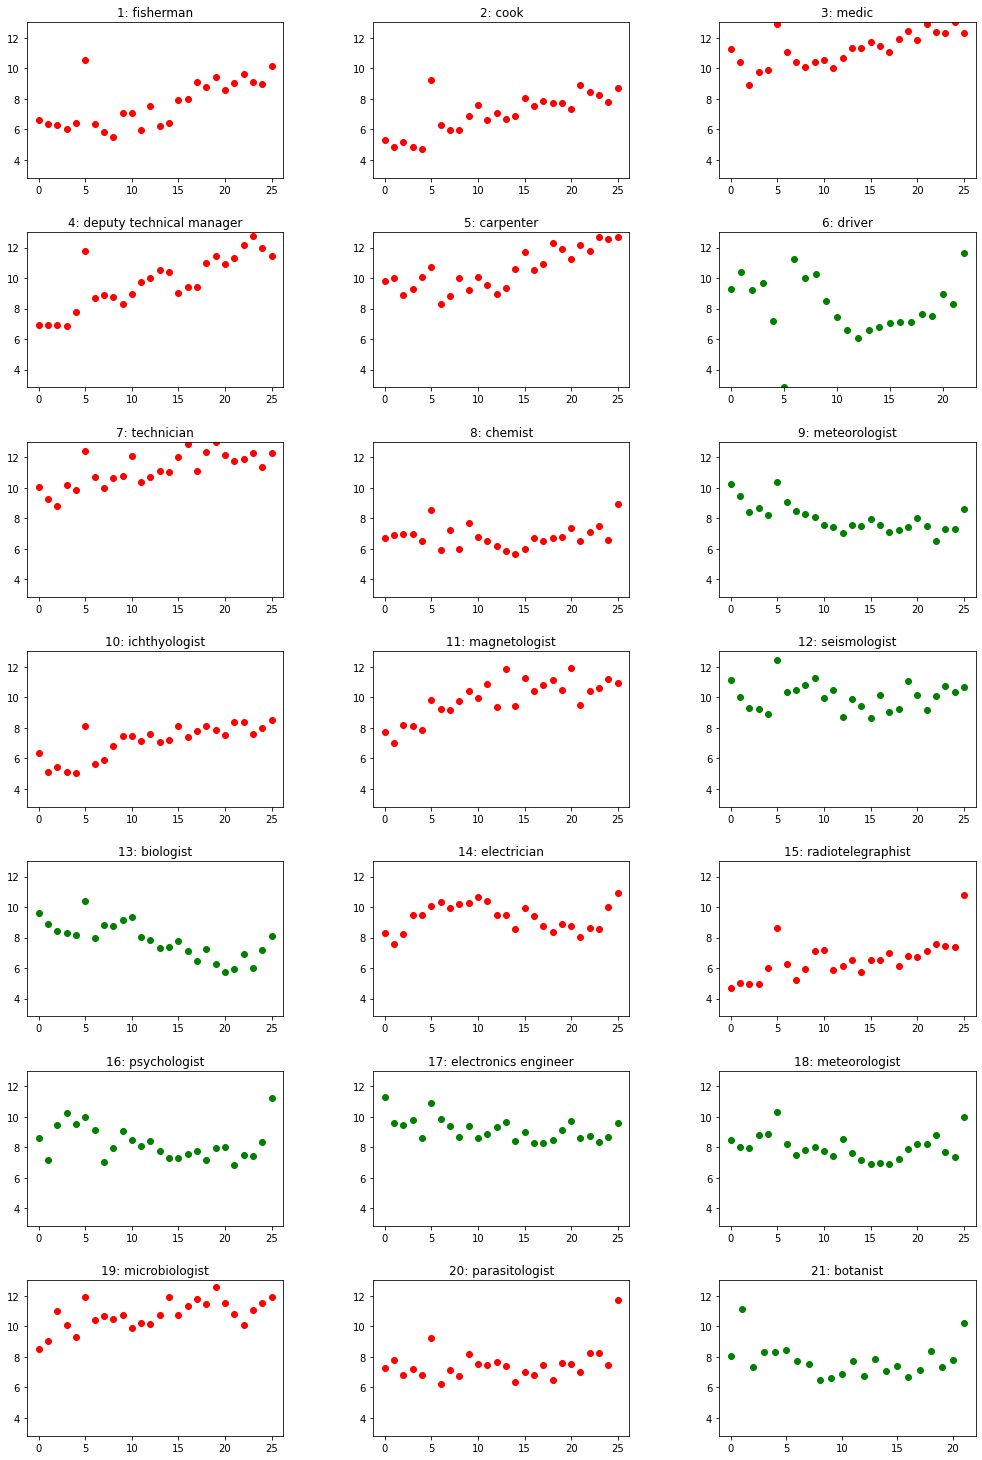

In [70]:
find_max = max([max(el) for el in average_incoming_distance_per_session_per_man])
find_min = min([min(el) for el in average_incoming_distance_per_session_per_man])
matplotlib.pyplot.figure(figsize=(17, 26))
plot_rows_no = 7
plot_cols_no = 3

for man in ppl_professions.keys():
    matplotlib.pyplot.subplot(plot_rows_no, plot_cols_no, man)
    matplotlib.pyplot.title(str(man) + ": " + ppl_professions[man])
    plot_color = 'go' if average_incoming_distance_slope_per_man[man][0] < 0 else 'ro'
    matplotlib.pyplot.plot(average_incoming_distance_per_session_per_man[man - 1], plot_color) # -1 since I index plot_ppl from 0    
    matplotlib.pyplot.ylim(find_min, find_max)

matplotlib.pyplot.subplots_adjust(hspace=0.35, wspace=0.35)

matplotlib.pyplot.show()

<b>These are insights</b> I see after looking on the charts: <br>
    <ul>
    <li>Something happened around session no. 5 - that is between 11.02.79 and 27.02.79 It affected one's both outgoing and incoming relations</li>
    <li>People were consistent in their reports.</li>
    <li>There are significant differences between how people view others and how they were seen.</li>
    </ul>
<br>
Botanist have some data missing for first 4 sessions, that's why we see only 21 records on the chart.

##### Let me create a wieghted graph of relations, one for each session:

In [77]:
session_graphs = {x: networkx.MultiGraph() for x in sorted_filenames.keys()}
for n, session_graph in session_graphs.items():
    session_graph.add_nodes_from(ppl_professions.keys())
    if n < 10:
        session_graph.remove_node(6)   # no. 6 got on site 25.04.79 -> present from session no. 10
    if n < 5:
        session_graph.remove_node(21)  # data is missing for sessions 1-4
    for man in session_graph.nodes():
        for other in session_graph.nodes():
                if man - 1 != other - 1:
                    the_weight = people_data[man - 1].distances[n][other - 1]   # -1 since i refer to lists, not dictionaries
                    if the_weight is not None:
                        session_graph.add_edge(man, other, weight=the_weight)

Example labeled graph from session 5


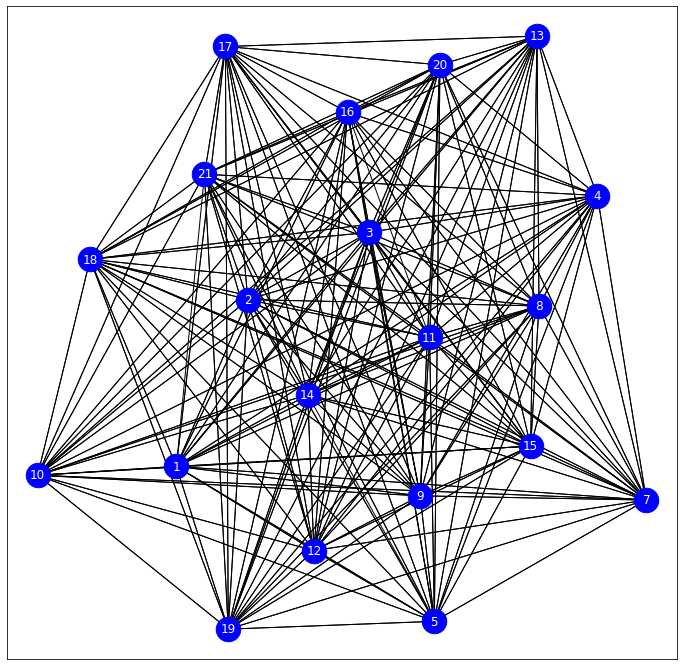

In [78]:
rand_session_1 = int(numpy.random.rand() * 26) + 1
print("Example labeled graph from session " + str(rand_session_1))
matplotlib.pyplot.figure(figsize=(12,12)) 
networkx.draw_networkx(session_graphs[rand_session_1], node_color='#0000ff', font_color='#ffffff', node_size=600)

Example labeled graph from session 15


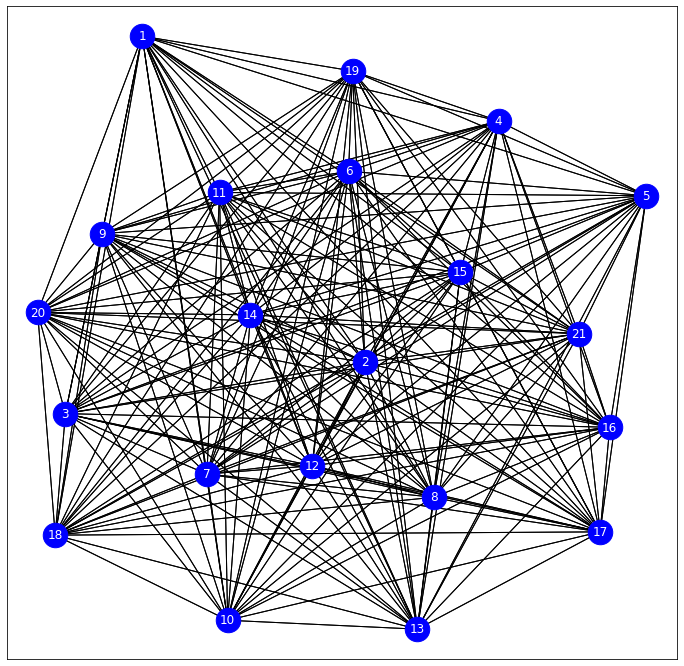

In [79]:
rand_session_2 = int(numpy.random.rand() * 26) + 1
print("Example labeled graph from session " + str(rand_session_2))
matplotlib.pyplot.figure(figsize=(12,12)) 
networkx.draw_networkx(session_graphs[rand_session_2], node_color='#0000ff', font_color='#ffffff', node_size=600)

##### Notice that edges (and thus nodes' ditances) are represented based on sum* of distances (from object Person) - that means, it's not only how particular person viewed others but also how he has been viewed by others - which is something different than I considered before as the mean. The mean was only the measure how particular person viewed others; not vice versa.

Both example graphs show that the cook (no. 2) was quite popular, even if himself viewed himself distanced (which is interesting).

*I know this from debugging the process of graph creation

##### How changed the graphs centrality over the sessions?
Closeness centrality of a node is the reciprocal of the average shortest path distance to considered node over all n-1 reachable nodes - https://en.wikipedia.org/wiki/Closeness_centrality

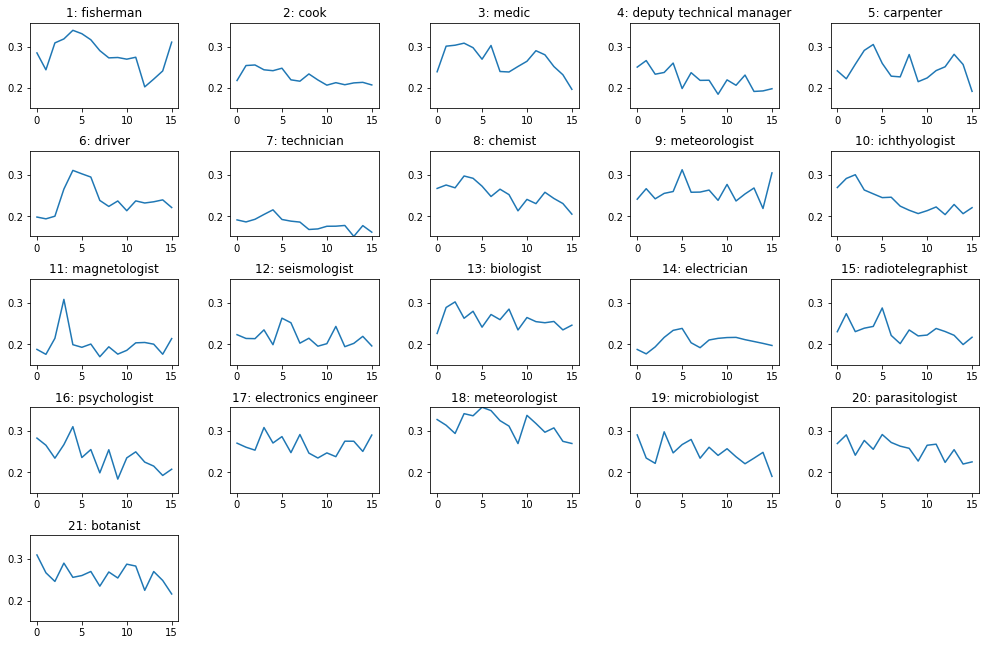

In [25]:
closeness_centrality_per_session = []
for session_graph in session_graphs.values():
    closeness_centrality_per_session.append(networkx.algorithms.centrality.closeness_centrality(session_graph, distance="weight"))

closeness_by_man =  {n: [] for n in ppl_professions.keys()}
for man in closeness_by_man.keys():
    for session_no in range(10, 26):   # values considered from session no. 10, when everybody was on site
        closeness_by_man[man].append(closeness_centrality_per_session[session_no][man])
        
find_max = max([max(el) for el in closeness_by_man.values()])
find_min = min([min(el) for el in closeness_by_man.values()])
matplotlib.pyplot.figure(figsize=(17, 11))
plot_rows_no = 5
plot_cols_no = 5

for man in ppl_professions.keys():
    matplotlib.pyplot.subplot(plot_rows_no, plot_cols_no, man)
    matplotlib.pyplot.title(str(man) + ": " + ppl_professions[man])
    matplotlib.pyplot.plot(closeness_by_man[man]) # -1 since I index plot_ppl from 0
    matplotlib.pyplot.ylim(find_min, find_max)

matplotlib.pyplot.subplots_adjust(hspace=0.5, wspace=0.35)

matplotlib.pyplot.show()

What is different about the above results is that they represent closeness <b>not</b> previously calculated distance. The distance was a metric of how far one viewed others, but told nothing about how others see particular person.
Closeness is calculated on weigths as seen in example graphs - and those are sum of outgoing and incoming relation value (as calculated in object Person)

Please notice, charts show data only for last 15 sessions, since only then everybody was present (since driver's ariival on 10th session and missing data for botanist for 1-4th sessions).

In [24]:
cumulative_centrality_per_session = {n: 0 for n in ppl_professions.keys()}
for session in closeness_centrality_per_session:
    for i, value in session.items():
        cumulative_centrality_per_session[i] += value
sorted_cumulative_centrality_per_session = {k: v for k, v in sorted(cumulative_centrality_per_session.items(), key=lambda item: item[1])}
print("Sorted cumulative centrality per session: ")
print()
for key, value in sorted_cumulative_centrality_per_session.items():
    print(f"{ppl_professions[key]:25} | {value:8.4f}")

Sorted cumulative centrality per session: 

driver                    |   3.9698
magnetologist             |   5.6983
botanist                  |   5.7109
technician                |   5.7621
electrician               |   5.7897
seismologist              |   6.1222
radiotelegraphist         |   6.6511
cook                      |   6.6646
deputy technical manager  |   6.6786
psychologist              |   6.8073
carpenter                 |   6.8403
ichthyologist             |   6.9435
chemist                   |   6.9484
meteorologist             |   6.9498
parasitologist            |   7.0858
microbiologist            |   7.1818
electronics engineer      |   7.3665
fisherman                 |   7.6226
biologist                 |   7.7535
medic                     |   7.9417
meteorologist             |   7.9472


Let me create a summary graph, based on mean weigths for all sessions' relations.

In [97]:
people_no = 21   # number of people
session_no = 26   # number of sessions
mean_weight_per_man = {n + 1: [[0 for p in range(session_no + 1)] for s in range(people_no + 1)] for n in range(people_no)} # people_no-1 since I skip self-relation
for i, graph in session_graphs.items():
    for edge in graph.edges.data("weight", default=True):
        man_no = edge[0]
        other_no = edge[1]
        distance = edge[2]
        mean_weight_per_man[man_no][other_no][i] += distance
        
# get mean weights(distances) of relations, per man per session per relation
for man_no in mean_weight_per_man.keys():
    others_list = mean_weight_per_man[man_no]
    for list_no in range(len(others_list)):
        session_list = mean_weight_per_man[man_no][list_no]
        for session_no in range(len(session_list)):
            mean_weight_per_man[man_no][list_no][session_no] = mean_weight_per_man[man_no][list_no][session_no] / 2 # mean of incoming and outgoing distances

# get mean distances between people for all sessions:
for man_no in mean_weight_per_man.keys():
    others_list = mean_weight_per_man[man_no]
    for list_no in range(len(others_list)):
        mean_weight_per_man[man_no][list_no] = numpy.mean(mean_weight_per_man[man_no][list_no])
        
# create summary graph:
summary_graph = networkx.MultiGraph()
summary_graph.add_nodes_from(mean_weight_per_man.keys())
for man in summary_graph.nodes():
    for other in summary_graph.nodes():
        if man != other:
            summary_graph.add_edge(man, other, weight=mean_weight_per_man[man][other - 1])

##### Let's plot the summary graph

The graph represents mean distance across all sessions. Please notice that each edge representing the distance is itself an 
average of the incoming and outgoing distance from a person (average of how a particular man view other man and how the other view the first).

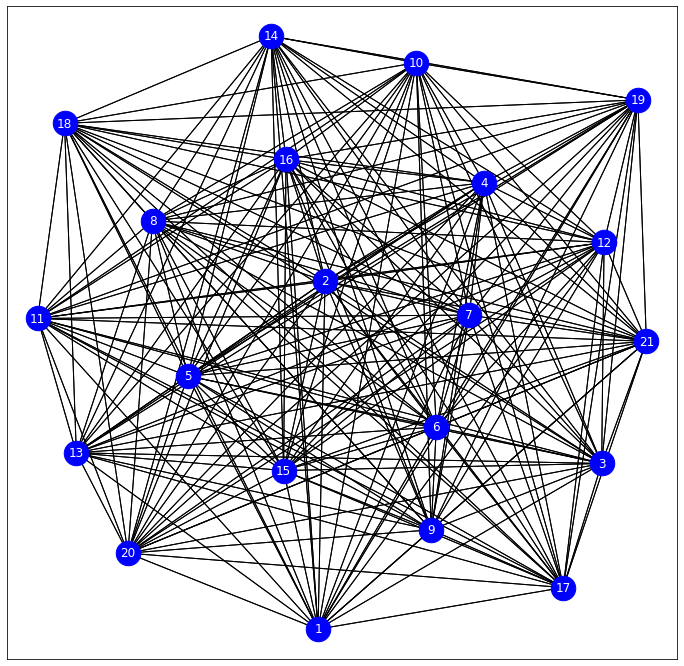

In [98]:
matplotlib.pyplot.figure(figsize=(12,12)) 
networkx.draw_networkx(summary_graph, node_color='#0000ff', font_color='#ffffff', node_size=600)

Consistently I can see 2 (cook), 12 (seismologist) and 15 (radiotelegraphist) closer to every other.
This however might mean that they were 'average neutral' and not belonging to any social group (community), distancing equally to every other.

This brings me to the topic of groups, substantially hard since "the main elements of the problem themselves, i. e. the concepts of community and partition, are not rigorously defined, and require some degree of arbitrariness and/or common sense." as is written by Santo Fortunato in "Community detection in graphs" from 25.01.2010 (https://arxiv.org/abs/0906.0612)

##### What groups did people created, if any?

The topic of groups and identifying them is hard since not only its not well defined, but also there are many misconceptions and ambiguous word use. By goup I understand <a href="https://en.wikipedia.org/wiki/Social_group">social group</a>, not subject of <a href="https://en.wikipedia.org/wiki/Group_(mathematics)">group theory</a> nor a <a href="https://en.wikipedia.org/wiki/Clique_(graph_theory)">clique</a>.

<b>People can be part of more than one group at a time.</b> They can also switch groups - this is fascinating but does not help to grasp the nature of events.

I'll define a group as a number of people with closer distanse (both incoming and outgoing) to each other than the global average. I'll see what groups could be found, and what other if I redefine the distance condition to be closer by a one standard deviation of the global average distance.

In [99]:
print(mean_weight_per_man)

{1: [0.0, 0.0, 7.197599305717966, 5.308283400212479, 7.351125058720925, 4.740171781605986, 4.269561159539208, 6.83226538851212, 7.878744588108966, 7.753310070342298, 3.4050175279452732, 5.934456909524296, 7.697451270975339, 4.85671647659728, 8.687614010807758, 8.1966707745879, 4.7443707943803375, 5.153815641186468, 4.29331527174209, 5.619853699941344, 7.427789076231671, 6.049034879791519], 2: [0.0, 0.0, 0.0, 6.927264096219288, 8.67560893011388, 11.62231624190728, 9.537111029830905, 10.358138675945735, 15.768815572342502, 13.921718843739516, 4.801946315490211, 14.299926465889527, 18.578864239174546, 14.57936735196236, 15.526813772286538, 10.53585555208018, 12.056571623472884, 12.6586248646364, 14.277696938997678, 15.97761300451964, 17.367356096911138, 15.252535823686937], 3: [0.0, 0.0, 0.0, 0.0, 3.325359312175667, 5.331751480329386, 7.386000804788535, 6.410335732442703, 12.843143867922755, 7.671433973524154, 4.404878102926157, 9.415708010080296, 9.291796238336506, 3.924816051528752, 11.

### Summary and insights

I've done what I believe is a summary statistics about the data I received.
The data pertains to human subjective view of relations between small group of people staying in difficult conditions over the many months.

I've transformed the data from information about points coordinates marked on charts to distances. This unfortunatelly has caused the loss about the plausible patterns people used to mark their opinions.
With the distances organised by people by sessions, I've lookod how those changed through time, I've created sample graphs of parallel (and mutual) relations and used the graphs to get closeness centralities. Finally I've plotted graph defined by mean closeness centralities across all sessions, and peeked into possible groups of people.

My insights are:
<ul>
    <li>There was an important event between sessions no. 4 and 5. Majority of people felt more distanced from others afterwards.</li>
    <li>There is an important difference between how one view others, and how other view particular person - these however needs further investigation and consulting statistical importance.</li>
    <li> People were consistent in their answers - it is worth checking other variables, like psychology test filled before the journey to Antarctics.</li>
    <li> </li>
    </ul>